<a href="https://colab.research.google.com/github/mohd-muzamil/ML_DL/blob/main/MNIST_Classifier_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## <b>MNIST</b> Classifier using pytorch

## 0. Computer vision libraries in PyTorch


| PyTorch module | What does it do? |
| ----- | ----- |
| [`torchvision`](https://pytorch.org/vision/stable/index.html) | Contains datasets, model architectures and image transformations often used for computer vision problems. |
| [`torchvision.datasets`](https://pytorch.org/vision/stable/datasets.html) | Here you'll find many example computer vision datasets for a range of problems from image classification, object detection, image captioning, video classification and more. It also contains [a series of base classes for making custom datasets](https://pytorch.org/vision/stable/datasets.html#base-classes-for-custom-datasets). |
| [`torchvision.models`](https://pytorch.org/vision/stable/models.html) | This module contains well-performing and commonly used computer vision model architectures implemented in PyTorch, you can use these with your own problems. | 
| [`torchvision.transforms`](https://pytorch.org/vision/stable/transforms.html) | Often images need to be transformed (turned into numbers/processed/augmented) before being used with a model, common image transformations are found here. | 
| [`torch.utils.data.Dataset`](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) | Base dataset class for PyTorch.  | 
| [`torch.utils.data.DataLoader`](https://pytorch.org/docs/stable/data.html#module-torch.utils.data) | Creates a Python iteralbe over a dataset (created with `torch.utils.data.Dataset`). |

In [1]:
# Import PyTorch
import torch
from torch import nn

from torch.utils.data import DataLoader

# Import torchvision 
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

try:
  from torchmetrics import Accuracy
except:
  !pip install torchmetrics
  from torchmetrics import Accuracy

# Import matplotlib for visualization
import matplotlib.pyplot as plt
from tqdm import tqdm

# Check versions
# Note: your PyTorch version shouldn't be lower than 1.10.0 and torchvision version shouldn't be lower than 0.11
print(f"PyTorch version: {torch.__version__}\ntorchvision version: {torchvision.__version__}")

PyTorch version: 1.12.1+cu113
torchvision version: 0.13.1+cu113


In [2]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [3]:
#using GPU accelerator
!nvidia-smi

Fri Aug 19 23:18:03 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P8    13W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## 1. Getting a dataset
MNIST stands for Modified National Institute of Standards and Technology.

The [original MNIST dataset](https://en.wikipedia.org/wiki/MNIST_database) contains thousands of examples of handwritten digits (from 0 to 9) and was used to build computer vision models to identify numbers for postal services.

In [4]:
# Setup training data
train_data = datasets.MNIST(
    root="data", # where to download data to?
    train=True, # get training data
    download=True, # download data if it doesn't exist on disk
    transform=ToTensor(), # images come as PIL format, we want to turn into Torch tensors
    target_transform=None # you can transform labels as well
)

# Setup testing data
test_data = datasets.MNIST(
    root="data",
    train=False, # get test data
    download=True,
    transform=ToTensor()
)

In [5]:
# How many samples are there? 
len(train_data.data), len(train_data.targets), len(test_data.data), len(test_data.targets)

(60000, 60000, 10000, 10000)

In [6]:
# See classes
class_names = train_data.classes
class_names

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

### 1.1 Visualizing our data

Image shape: torch.Size([1, 28, 28])


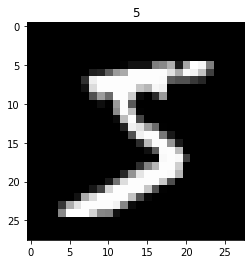

In [7]:
image, label = train_data[0]
print(f"Image shape: {image.shape}")
plt.imshow(image.squeeze(), cmap="gray") # image shape is [1, 28, 28] (colour channels, height, width)
plt.title(label);

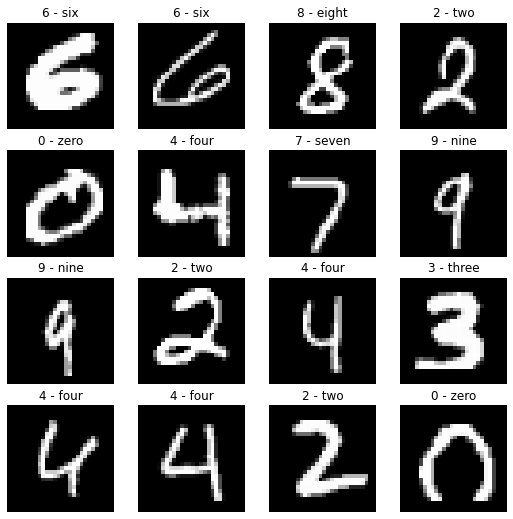

In [8]:
# Plot more images
torch.manual_seed(42)
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(class_names[label])
    plt.axis(False);

## 2. Prepare DataLoader
The next step is to prepare it with a [`torch.utils.data.DataLoader`](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) or `DataLoader` for short.

In [9]:
# Setup the batch size hyperparameter
BATCH_SIZE = 32

# Turn datasets into iterables (batches)
train_dataloader = DataLoader(train_data, # dataset to turn into iterable
    batch_size=BATCH_SIZE, # how many samples per batch? 
    shuffle=True # shuffle data every epoch?
)

test_dataloader = DataLoader(test_data,
    batch_size=BATCH_SIZE,
    shuffle=False # don't necessarily have to shuffle the testing data
)

# Let's check out what we've created
print(f"Dataloaders: {train_dataloader, test_dataloader}") 
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x7f72e6727a10>, <torch.utils.data.dataloader.DataLoader object at 0x7f72e6727a50>)
Length of train dataloader: 1875 batches of 32
Length of test dataloader: 313 batches of 32


## 3. Model 0: Build a baseline model

In [10]:
# Check out what's inside the training dataloader
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

In [11]:
 # Create a flatten layer
flatten_model = nn.Flatten() # all nn modules function as a model (can do a forward pass)

# Get a single sample
x = train_features_batch[0]

# Flatten the sample
output = flatten_model(x) # perform forward pass

# Print out what happened
print(f"Shape before flattening: {x.shape} -> [color_channels, height, width]")
print(f"Shape after flattening: {output.shape} -> [color_channels, height*width]")

# Try uncommenting below and see what happens
#print(x)
#print(output)

Shape before flattening: torch.Size([1, 28, 28]) -> [color_channels, height, width]
Shape after flattening: torch.Size([1, 784]) -> [color_channels, height*width]


In [12]:
from torch import nn
class MNISTModelV0(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(), # neural networks like their inputs in vector form
            nn.Linear(in_features=input_shape, out_features=hidden_units), # in_features = number of features in a data sample (784 pixels)
            nn.Linear(in_features=hidden_units, out_features=output_shape)
        )
    
    def forward(self, x):
        return self.layer_stack(x)

In [13]:
torch.manual_seed(42)

# Need to setup model with input parameters
model_0 = MNISTModelV0(input_shape=784, # one for every pixel (28x28)
    hidden_units=10, # how many units in the hiden layer
    output_shape=len(class_names) # one for every class
)
model_0.to(device) # keep model on CPU to begin with 

MNISTModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [14]:
# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss() # this is also called "criterion"/"cost function" in some places
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)
accuracy_fn = Accuracy().to(device)

In [15]:
# function to time our experiments
from timeit import default_timer as timer 
def print_train_time(start: float, end: float, device: torch.device = None):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format). 
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

### Training loop

In [42]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    train_loss, train_acc = 0, 0
    for batch, (X, y) in enumerate(data_loader):
        # Send data to GPU
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(preds=y_pred.argmax(dim=1),
                                 target=y).to(device) # Go from logits -> pred labels

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    # Calculate loss and accuracy per epoch and print out what's happening
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")
    
    return train_loss.cpu().detach().numpy(), train_acc.cpu().detach().numpy()

### Test loop

In [43]:
def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    test_loss, test_acc = 0, 0
    model.eval() # put model in eval mode
    # Turn on inference context manager
    with torch.inference_mode(): 
        for X, y in data_loader:
            # Send data to GPU
            X, y = X.to(device), y.to(device)
            
            # 1. Forward pass
            test_pred = model(X)
            
            # 2. Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(
                preds=test_pred.argmax(dim=1), # Go from logits -> pred labels
                target=y
            ).to(device)
        
        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 0.27906 | Train accuracy: 0.92%


 33%|███▎      | 1/3 [00:11<00:22, 11.19s/it]

Test loss: 0.27713 | Test accuracy: 0.92%

Epoch: 1
---------
Train loss: 0.27668 | Train accuracy: 0.92%


 67%|██████▋   | 2/3 [00:22<00:11, 11.51s/it]

Test loss: 0.27621 | Test accuracy: 0.92%

Epoch: 2
---------
Train loss: 0.27483 | Train accuracy: 0.92%


100%|██████████| 3/3 [00:34<00:00, 11.57s/it]

Test loss: 0.27832 | Test accuracy: 0.92%

Train time on cuda: 34.736 seconds


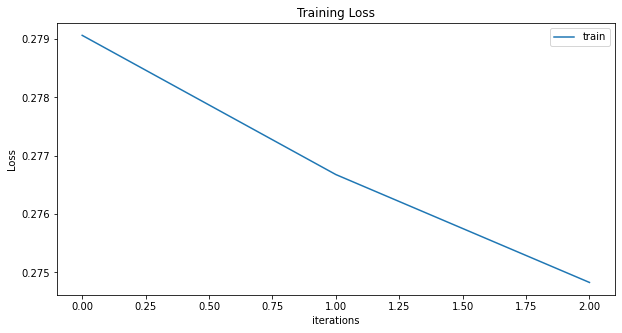

In [44]:
torch.manual_seed(42)

# Measure time
from timeit import default_timer as timer
train_time_start_on_gpu = timer()

epochs = 3
train_losses = []
train_acc = []

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    loss, acc = train_step(data_loader=train_dataloader, 
        model=model_0, 
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn
    )
    train_losses.append(loss)
    train_acc.append(acc)

    test_step(data_loader=test_dataloader,
        model=model_0,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn
    )

train_time_end_on_gpu = timer()
total_train_time_model_1 = print_train_time(start=train_time_start_on_gpu,
                                            end=train_time_end_on_gpu,
                                            device=device)


plt.figure(figsize=(10,5))
plt.title("Training Loss")
plt.plot(train_losses, label="train")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

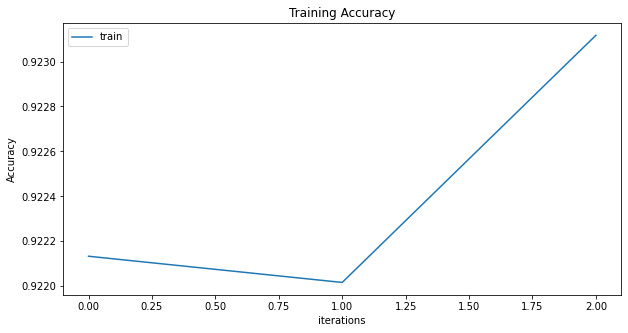

In [47]:
plt.figure(figsize=(10,5))
plt.title("Training Accuracy")
plt.plot(train_acc, label="train")
plt.xlabel("iterations")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [48]:
torch.manual_seed(42)
def eval_model(model: torch.nn.Module, 
               data_loader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               accuracy_fn):
    """Returns a dictionary containing the results of model predicting on data_loader.

    Args:
        model (torch.nn.Module): A PyTorch model capable of making predictions on data_loader.
        data_loader (torch.utils.data.DataLoader): The target dataset to predict on.
        loss_fn (torch.nn.Module): The loss function of model.
        accuracy_fn: An accuracy function to compare the models predictions to the truth labels.

    Returns:
        (dict): Results of model making predictions on data_loader.
    """
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:

            X = X.to(device)
            y = y.to(device)
            # Make predictions with the model
            y_pred = model(X)
            
            # Accumulate the loss and accuracy values per batch
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(preds=y_pred.argmax(dim=1), target=y) # For accuracy, need the prediction labels (logits -> pred_prob -> pred_labels)
        
        # Scale loss and acc to find the average loss/acc per batch
        loss /= len(data_loader)
        acc /= len(data_loader)
        
    return {"model_name": model.__class__.__name__, # only works when model was created with a class
            "model_loss": loss.item(),
            "model_acc": acc}

# Calculate model 0 results on test dataset
model_0_results = eval_model(model=model_0, data_loader=test_dataloader,
    loss_fn=loss_fn, accuracy_fn=accuracy_fn
)
model_0_results

{'model_name': 'MNISTModelV0',
 'model_loss': 0.2783176004886627,
 'model_acc': tensor(0.9224, device='cuda:0')}

## 4. Making a confusion matrix for further prediction evaluation

In [49]:
# Import tqdm for progress bar
from tqdm.auto import tqdm

# 1. Make predictions with trained model
y_preds = []
model_0.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc="Making predictions"):
    # Send data and targets to target device
    X, y = X.to(device), y.to(device)
    # Do the forward pass
    y_logit = model_0(X)
    # Turn predictions from logits -> prediction probabilities -> predictions labels
    y_pred = torch.softmax(y_logit.squeeze(), dim=0).argmax(dim=1)
    # Put predictions on CPU for evaluation
    y_preds.append(y_pred.cpu())
# Concatenate list of predictions into a tensor
y_pred_tensor = torch.cat(y_preds)

Making predictions:   0%|          | 0/313 [00:00<?, ?it/s]

In [51]:
# See if torchmetrics exists, if not, install it
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
except:
    !pip install -q torchmetrics -U mlxtend # <- Note: If you're using Google Colab, this may require restarting the runtime
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")

mlxtend version: 0.14.0
     |████████████████████████████████| 1.3 MB 35.7 MB/s 
mlxtend version: 0.14.0


In [54]:
# Import mlxtend upgraded version
import mlxtend 
print(mlxtend.__version__)
# assert int(mlxtend.__version__.split(".")[1]) >= 19 # should be version 0.19.0 or higher

0.14.0


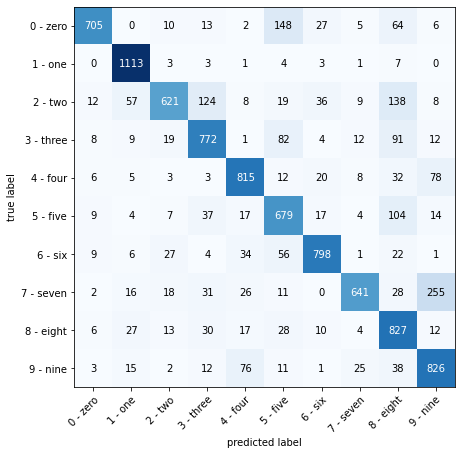

In [53]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 2. Setup confusion matrix instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(class_names))
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=test_data.targets)

# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy 
    class_names=class_names, # turn the row and column labels into class names
    figsize=(10, 7)
);

## 5. Save and reload the model

In [55]:
from pathlib import Path

# Create models directory (if it doesn't already exist), see: https://docs.python.org/3/library/pathlib.html#pathlib.Path.mkdir
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, # create parent directories if needed
                 exist_ok=True # if models directory already exists, don't error
)

# Create model save path
MODEL_NAME = "03_pytorch_computer_vision_model.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(), # only saving the state_dict() only saves the learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models/03_pytorch_computer_vision_model.pth


In [63]:
# Create a new instance of FashionMNISTModelV2 (the same class as our saved state_dict())
# Note: loading model will error if the shapes here aren't the same as the saved version
loaded_model_0 = MNISTModelV0(input_shape=28*28, 
                                    hidden_units=10, # try changing this to 128 and seeing what happens 
                                    output_shape=10) 

# Load in the saved state_dict()
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

# Send model to GPU
loaded_model_0 = loaded_model_0.to(device)
loaded_model_0

MNISTModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [64]:
# Evaluate loaded model
torch.manual_seed(42)

loaded_model_0_results = eval_model(
    model=loaded_model_0,
    data_loader=test_dataloader,
    loss_fn=loss_fn, 
    accuracy_fn=accuracy_fn
)

loaded_model_0_results

{'model_name': 'MNISTModelV0',
 'model_loss': 0.2783176004886627,
 'model_acc': tensor(0.9224, device='cuda:0')}

In [65]:
# Check to see if results are close to each other (if they are very far away, there may be an error)
torch.isclose(torch.tensor(model_0_results["model_loss"]), 
              torch.tensor(loaded_model_0_results["model_loss"]),
              atol=1e-08, # absolute tolerance
              rtol=0.0001) # relative tolerance

tensor(True)